# Happy Hotel

You've just joined the data team at a large hotel chain. Your specific team is embedded in the CX (customer experience) division. Each day you receive hundreds of reviews of your 10 hotels from your customers. Each review consists of a free-form text review and a report of "happy" or "not happy". A product manager on your team wants to understand each hotel's performance at a more granular level; they want to build a product to identify topics within reviews. All of your reviews are unlabeled, and it's infeasible to label them by hand.

* Design and execute a method to identify topics within the reviews.
* For each topic, find a robust means of assigning a score to each hotel in that topic.
* For each of the ten hotels, what specific-to-that-hotel recommendations would you make to their general managers?
* Engineering Challenge: How would you design this system to update over time? How would you persist topics from one timestep/update to another? How would you design your scores so they can meaningfully understand when they’re doing better?

In [212]:
%matplotlib inline
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt

In [213]:
happy = pd.read_csv('./data/hotel_happy_reviews.csv')

In [214]:
nothappy = pd.read_csv('./data/hotel_not_happy_reviews.csv')

In [215]:
happy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26521 entries, 0 to 26520
Data columns (total 4 columns):
User_ID        26521 non-null object
Description    26521 non-null object
Is_Response    26521 non-null object
hotel_ID       26521 non-null int64
dtypes: int64(1), object(3)
memory usage: 828.9+ KB


In [216]:
nothappy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12411 entries, 0 to 12410
Data columns (total 4 columns):
User_ID        12411 non-null object
Description    12411 non-null object
Is_Response    12411 non-null object
hotel_ID       12411 non-null int64
dtypes: int64(1), object(3)
memory usage: 388.0+ KB


In [217]:
happy.head(10)

,User_ID,Description,Is_Response,hotel_ID
0,id10329,Stayed here with husband and sons on the way t...,happy,8
1,id10331,We had - rooms. One was very nice and clearly ...,happy,3
2,id10333,My wife & I stayed in this glorious city a whi...,happy,3
3,id10334,My boyfriend and I stayed at the Fairmont on a...,happy,7
4,id10336,"Steps off Times Square, nice rooms, stayed - n...",happy,3
5,id10337,"Me, the Wife and - kids stayed here on Valenti...",happy,7
6,id10339,I highly recommend the Hawthorne Terrace as an...,happy,8
7,id10340,I found the hotel clean and nicely located. Go...,happy,3
8,id10341,Stayed at the Elan from --th to --th October a...,happy,1
9,id10344,We stayed here for - nights and were really ha...,happy,5


In [218]:
nothappy.head(10)

,User_ID,Description,Is_Response,hotel_ID
0,id10326,The room was kind of clean but had a VERY stro...,not happy,3
1,id10327,I stayed at the Crown Plaza April -- - April -...,not happy,9
2,id10328,I booked this hotel through Hotwire at the low...,not happy,3
3,id10330,My girlfriends and I stayed here to celebrate ...,not happy,3
4,id10332,My husband and I have stayed in this hotel a f...,not happy,7
5,id10335,"Wonderful staff, great location, but it was de...",not happy,3
6,id10338,We stay at the Jolly Madison over the Xmas per...,not happy,8
7,id10342,Priceline sent us to this hotel after acceptin...,not happy,7
8,id10343,"Old and cheap furnitures,our chair was simply ...",not happy,3
9,id10345,"The service was fine, but the hotel itself fel...",not happy,3


In [222]:
# let's combine the good and bad reviews

reviews = happy.append(nothappy, ignore_index=True)
reviews.reset_index(inplace=True)

In [231]:
import seaborn as sns

# Quick EDA

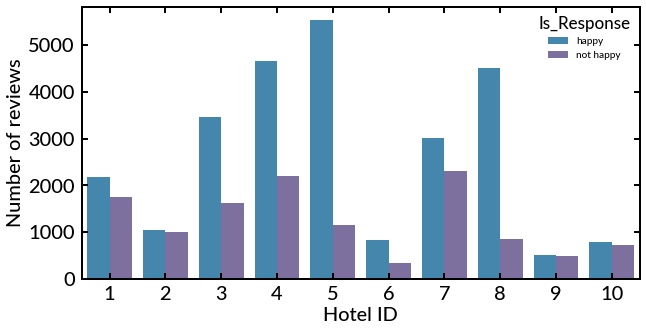

In [239]:
# look at the people who are and aren't happy with their stay

hotel_review_counts = reviews.groupby(['hotel_ID','Is_Response'])['index'].count()
hotel_review_counts = pd.DataFrame(hotel_review_counts).reset_index()
hotel_review_counts

fig,ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(x="hotel_ID", y="index", hue="Is_Response", data=hotel_review_counts)
ax.set_ylabel('Number of reviews')
ax.set_xlabel('Hotel ID')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
plt.savefig('./plots/hotel_breakdown.png', bbox='tight')

# Formulate plan of attack

1. Decide which topics are in reviews...

To do this we are gonna need to work with the descriptions. We'll need to parse each paragraph. Then clean each paragraph of all the unimportant words. Homogenize the words (lower case) and then tokenize the words. For this we are gonna use `nltk`. I think for this project we don't care if the words are broken up into single words. For the reciepes, we needed to keep the ingredients together, but for this we don't care as much.

2. Assign score for each topic... 

Basically, we are gonna catagorize the reviews using the topics from 1. then assign a score some how. I dunno how to do it immediately. I'll think about it some more. 


In [40]:
# clean the paragraphs

import string

# download stopwords list to filter out in sentences
# nltk.download('stopwords')
from nltk.corpus import stopwords

# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /home/boada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [242]:
def clean_descripts(descript):
    """
    Processes text by 1) convert words to lowercase 
    and remove non alphabetic characters, 2)tokenize 
    the text and separate every sentence into a list 
    of words, 3)remove stopwords and stem each word 
    to the root

    Parameters:
    ----------
    text : row with text in pandas column

    Returns:
    -------
    clean_text : cleaned text based on processing
    methods
    """
    
    # lower case all the words
    descript = descript.lower()
    
    # remove all the punctuation
    descript = descript.translate(str.maketrans('', '', string.punctuation))
    
    # 'tokenize the cleaned text'
    tokenized = descript.split(' ')
    
    # stem or maybe lemmatize the words -- gonna start with stemming
#     clean_text = [
#         stemmer.stem(word) for word in tokenized
#         if word not in stopwords.words('english')
#     ]
    clean_text = [
        lemma.lemmatize(word) for word in tokenized
        if word not in stopwords.words('english')
    ]
    

    # keep things as a long string to go into count vectorizer
    clean_text = ' '.join(clean_text)
    
    # return list of clean words
    return clean_text

In [ ]:
# clean the descriptions --takes a while to run ~ 5 minutes

reviews['clean_descript'] = reviews.Description.apply(lambda x: clean_descripts(x))

In [ ]:
reviews.head(10)

In [ ]:
reviews.info()

In [238]:
reviews.to_csv('./data/hotels_cleaned.csv', index=False)

# Use something called GenSim

After doing a bunch of googling. I see a lot of people using this package to do the topic analysis. 

# Extract Keywords from each review

I think we'll use TF-IDF to count the words and then extract the biggest keywords. 

This is inspired by: https://github.com/kavgan/nlp-in-practice/tree/master/tf-idf and I am gonna copy some code from that repo.

In [241]:
from sklearn.feature_extraction.text import CountVectorizer

#create a vocabulary of words, 
#ignore words that appear in 85% of documents, 
#eliminate stop words
cv = CountVectorizer(min_df=0.1, max_df=0.85, stop_words=stopwords.words('english'), lowercase=False)

word_count_vector = cv.fit_transform(reviews.clean_descript)

TypeError: expected string or bytes-like object

In [136]:
word_count_vector.shape

(26521, 96)

In [189]:
# let's limit the number of words we are gonna consider

cv = CountVectorizer(min_df=0.01, max_df=0.5, stop_words=stopwords.words('english'), max_features=10000, lowercase=False)
word_count_vector=cv.fit_transform(reviews.clean_descript)
word_count_vector.shape

(26521, 1037)

In [190]:
list(cv.vocabulary_.keys())[:10]

['stayed',
 'husband',
 'son',
 'way',
 'cruise',
 'loved',
 'great',
 'experience',
 'ask',
 'north']

In [191]:
list(cv.get_feature_names())[2000:2015]

[]

# Compute the IDF part

This is the same as using `sklearn.feature_extraction.text.TfidfVectorizer` which rolls these two steps into a single call.

In [192]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [193]:
# copied from github

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [240]:
indx = 4000

# you only needs to do this once
feature_names = cv.get_feature_names()

# get the document that we want to extract keywords from
doc=reviews.iloc[indx].clean_descript

#generate tf-idf for the given document
tf_idf_vector = tfidf_transformer.transform(cv.transform([doc]))

#sort the tf-idf vectors by descending order of scores
sorted_items = sort_coo(tf_idf_vector.tocoo())

#extract only the top n; n here is 10
keywords = extract_topn_from_vector(feature_names, sorted_items, 20)

# now print the results

print("\n=====Description=====")
print(reviews.iloc[indx].Description)
print("\n===Keywords===")
for k in keywords:
    print(k, keywords[k])

TypeError: expected string or bytes-like object

# Clustering?

I did some more reading and people have used clusters to identify broad groups of topics. 

In [145]:
from sklearn.cluster import KMeans

In [146]:
k_clusters = 10
model = KMeans(n_clusters=k_clusters, max_iter=100, n_init=1)

In [147]:
tf_idf_vector = tfidf_transformer.transform(cv.transform(reviews.clean_descript))
model.fit(tf_idf_vector)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=10, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [148]:
doc

'spent week hotel young child staff friendly seems genuinely work well together housekeeping front desk staff friendly knowledgeable also breakfast  plentiful continental breakfast included jimmy dean biscuit boiled egg perfect hot tub pool wellmaintained towel always supplied cant say enough good thing hotel really love hotel clean sheet comparable one would home complimentary computer printer helpful little market wonderful plus shuttle service dependable huge factor plus using shuttle received card driver could call ask shuttle room spacious odor room carpet dye hotel first choice san antonio also hotel quiet hear people room next door'

In [150]:
model.predict(tfidf_transformer.transform(cv.transform([doc])))

array([6], dtype=int32)

In [196]:
model.labels_[3000]

6

In [197]:
reviews.Description[model.labels_==6][:10]

7     I found the hotel clean and nicely located. Go...
9     We stayed here for - nights and were really ha...
10    This is everything you could want from a hotel...
22    Okay the hotel-motel may not be a - star appea...
31    I agree, not fancy. But everything we needed. ...
35    The Good - The room was really just my taste. ...
49    Just loved the Hilton Garden Inn in Tribeca-So...
66    Booked this hotel on a special deal, stay - ni...
68    An excellent hotel - for business or pleasure....
73    I stayed here one night on a business trip. Go...
Name: Description, dtype: object

In [201]:
reviews.Description[model.labels_==6][:10][22]

'Okay the hotel-motel may not be a - star appearance and the rooms are well they are rooms.. but for the money - I have a fridge, hot breakfast, free internet, nice pool and pool hang out area, quiet neighborhood day and night yet only blocks from stores, waterfront, and restaurants and a nice sized balcony and free milk and cookies at -pm. Not bad at all... \r\nBut it gets better - I am a priority club member (but anyone can be.. just sign up for free) and I must say its been a long time since I was greeted so kindly on check in (for being a valued priority club member), and given a check in present (lotion and razor in a beautiful carrying bag) and upgraded to a room looking towards the bay and allowed early check in (-- am) and a managers greeting from ----- every weekday with FREE ALCOHOL and nibbles. Okay.. I admit... I felt more """"""""""""""""""""""""""""""""special"""""""""""""""""""""""""""""""" staying here than staying at the Hilton last week... and holiday Inn costs almost

# LDA?

In [203]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [207]:
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print()
        print("Topic {}:".format(topic_idx),", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]) )
        print()
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(documents[doc_index])

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(reviews.clean_descript)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()


no_topics = 5
no_top_words = 6
no_top_documents = 1

# Run NMF
nmf_model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_

In [208]:
print("NMF Topics")
display_topics(nmf_H, nmf_W, tfidf_feature_names, reviews.clean_descript, no_top_words, no_top_documents)
print("--------------")

NMF Topics

Topic 0: room, night, bed, hotel, floor, bathroom

hotel  park avenue maybe im city rube street number caused u problem first taxi driver thought wanted park avenue th took u  block needed eventually learned tell driver wanted  park avenue th th
the hotel lobby nice couch lemon water available staff helpful one bellman saw waiting line front desk didnt want wait longer turned leave asked anything needed asked towel sent right away also staff able give u direction great nearby restaurant still served breakfast noon pershing square restaurant across grand central stationawesome french toast
we hadnt asked handicapped room thats got second floorroom  room ok size ceiling hotel bit lower im used room window frosted outside second nonopening window pane inside likely reduce noise based layout hotel im fairly certain window faced tiny airspace next building 
sufficient light come window daytime opened blind didnt feel like basement lack fresh air wasnt big deal except fact bathro

In [210]:

# CountVectorizer converts a set of documents to a matrix of token counts
tf_vectorizer = CountVectorizer(max_df=0.85, min_df=2, stop_words='english')

# fit_transform learns the vocabulary dictionary and returns a term-document matrix
tf = tf_vectorizer.fit_transform(reviews.clean_descript)
tf_feature_names = tf_vectorizer.get_feature_names()

# Run LDA
lda_model = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
lda_W = lda_model.transform(tf)
lda_H = lda_model.components_

print("LDA Topics")
display_topics(lda_H, lda_W, tf_feature_names, reviews.clean_descript, no_top_words, no_top_documents)

LDA Topics

Topic 0: la, hollywood, studio, concert, universal, beach

e un hotel con una ubicacion privilegiada cerca de todo dentro de lo mejor de chicago fuera ideal alguien que hable español en frente del recibidor lo unico malo e el aire acondicionado muy viejo el baño muy pequeño tiene desayuno incluido

Topic 1: meeting, service, conference, courtyard, marriott, driver

following provided excellent service us
kelly norton juan verduzco jr restaurant
maricarmen crus room

Topic 2: room, hotel, nice, bed, night, good

upon arrival
took time pulling reservation check valet parking  day learned needed bring bag put cart could take luggage cart outside car due fact step leading elevator thought id let mobility impairment know ramp go stair elevator one party noticed something ordinary
the room
the room spacious stayed two bed room main bedroom area small closet large powder room connected smallish bathroom semifull kitchen breakfast nook powder room present surprise featured oldschoo

https://github.com/frcamacho/HappyHotel/blob/master/HappyHotel-Topic%20model.ipynb

https://github.com/celialeddy/Insight_Data_Challenges/blob/master/Happy_Hotel/Happy%20Hotel%20Data%20Challenge.ipynb